In [33]:
# -------------------
# Imports and Setup
# -------------------

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from pathlib import Path
import joblib
import os

# Stonks Meme Aesthetic
plt.style.use("dark_background")
STONKS_GREEN = '#00ff9c'
STONKS_RED   = '#ff005c'
STONKS_BLUE  = '#00c3ff'
STONKS_PURP  = '#9d4edd'

FIG_DIR = Path("/figures")
FIG_DIR.mkdir(exist_ok=True)

# load the data
df = pd.read_csv("../Neural Network for Volatility Forecasting/data/processed/features.csv", index_col=0, parse_dates=True)
df.head()

,returns,rv_5,rv_21,bonds,curve_slope,target_vol
2016-03-16,0.005585,0.120164,0.146579,1.94,1.94,0.116551
2016-03-17,0.006574,0.116551,0.139259,1.91,1.91,0.062748
2016-03-18,0.004396,0.062748,0.136701,1.88,1.88,0.055433
2016-03-21,0.000985,0.055433,0.136448,1.92,1.92,0.050165
2016-03-22,-0.000878,0.050165,0.130868,1.94,1.94,0.079752


In [37]:
# ------------------------
# Define Prediction Task
# ------------------------

FEATURES = [
    "returns", "rv_5", "rv_21", "curve_slope"
]

TARGET = "target_vol"

X_raw = df[FEATURES].values
y_raw = df[TARGET].values

In [39]:
# ----------------
# Feature Scaling
# ----------------

# Create the models directory if it doesn't exist
os.makedirs("../models", exist_ok=True)

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X_raw)
y_scaled = scaler_y.fit_transform(y_raw.reshape(-1,1)).flatten()

joblib.dump(scaler_X, "../models/scaler_X.pkl")
joblib.dump(scaler_y, "../models/scaler_y.pkl")

['../models/scaler_y.pkl']

In [41]:
# -----------------
# Sequence Scaler
# -----------------

def make_sequences(X, y, seq_len=30):
    Xs, ys = [], []
    
    for i in range(len(X) - seq_len):
        Xs.append(X[i:i+seq_len])
        ys.append(y[i+seq_len])
        
    return np.array(Xs), np.array(ys)

# Built LSTM Sequence
SEQ_LEN = 30   # 30 trading days (~1.5 months)

X_seq, y_seq = make_sequences(X_scaled, y_scaled, SEQ_LEN)

sequence_dates = df.index[SEQ_LEN:]
np.save("../data/processed/sequence_dates.npy", sequence_dates.values)

print("Sequence shape:", X_seq.shape)
print("Target shape:", y_seq.shape)

Sequence shape: (2433, 30, 4)
Target shape: (2433,)


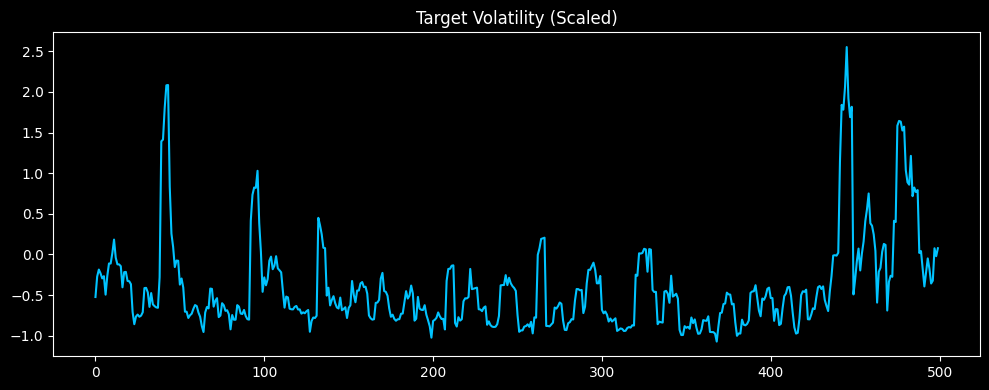

In [23]:
# Sanity Check
plt.figure(figsize=(10,4))
plt.plot(y_seq[:500], color=STONKS_BLUE)
plt.title("Target Volatility (Scaled)")
plt.tight_layout()
plt.savefig(FIG_DIR / "target_vol_preview.png", dpi=150)
plt.show()

In [25]:
# -------------------
# Model Validations
# -------------------

# 80-20
split = int(len(X_seq) * 0.8)

X_train = X_seq[:split]
X_val   = X_seq[split:]
y_train = y_seq[:split]
y_val   = y_seq[split:]

print("Train:", X_train.shape)
print("Validation:", X_val.shape)

# Walk-Forward
def walk_forward_splits(X, y, train_size, step=252):
    splits = []
    start = train_size
    
    while start + step < len(X):
        X_tr = X[:start]
        y_tr = y[:start]
        
        X_te = X[start:start+step]
        y_te = y[start:start+step]
        
        splits.append((X_tr, y_tr, X_te, y_te))
        start += step
        
    return splits

Train: (1946, 30, 4)
Validation: (487, 30, 4)


In [27]:
# ----------------------
# PyTorch Dataset Class
# ----------------------

class VolDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [29]:
# -------------------------
# Data Loaders and Exports
# -------------------------

BATCH_SIZE = 64

train_loader = DataLoader(
    VolDataset(X_train, y_train),
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_loader = DataLoader(
    VolDataset(X_val, y_val),
    batch_size=BATCH_SIZE,
    shuffle=False
)

# Saved Data
np.save("../Neural Network for Volatility Forecasting/data/processed/X_train.npy", X_train)
np.save("../Neural Network for Volatility Forecasting/data/processed/X_val.npy", X_val)
np.save("../Neural Network for Volatility Forecasting/data/processed/y_train.npy", y_train)
np.save("../Neural Network for Volatility Forecasting/data/processed/y_val.npy", y_val)